In [15]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import joblib
import random

# === Paths ===
base_dir = "/Users/gemwincanete/Thesis /datasets/mfccfeatures"
metadata_path = os.path.join(base_dir, "metadata.csv")

# === Load metadata ===
df = pd.read_csv(metadata_path)
print(df.head())

# === Classes from metadata ===
class_names = sorted(df['label'].unique())
print("Classes:", class_names)

X_train, y_train_labels = [], []
X_test, y_test_labels = [], []

# === Iterate rows using metadata ===
for _, row in df.iterrows():
    filename = row['filename']
    label = row['label']
    split = row['split']  # "train" or "test"

    # NOTE: folder structure is /<label>/<split>/<filename>.npy
    filepath = os.path.join(base_dir, label, split, filename)

    if not os.path.exists(filepath):
        print("Missing file:", filepath)
        continue

    mfcc = np.load(filepath)

    if split == "train":
        X_train.append(mfcc)
        y_train_labels.append(label)
    elif split == "test":
        X_test.append(mfcc)
        y_test_labels.append(label)

print(f"Loaded {len(X_train)} train and {len(X_test)} test samples.")

# === Encode labels ===
le = LabelEncoder()
integer_labels_train = le.fit_transform(y_train_labels)
integer_labels_test = le.transform(y_test_labels)

label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label mapping:", label_mapping)

# === One-hot encode ===
ohe = OneHotEncoder(sparse_output=False)
y_train = ohe.fit_transform(integer_labels_train.reshape(-1, 1))
y_test = ohe.transform(integer_labels_test.reshape(-1, 1))

# === Pad sequences to max train length ===
max_timesteps_train = max(mfcc.shape[1] for mfcc in X_train)
X_train = np.array([
    np.pad(mfcc, ((0, 0), (0, max_timesteps_train - mfcc.shape[1])), mode='constant')
    for mfcc in X_train
])
X_test = np.array([
    np.pad(mfcc, ((0, 0), (0, max_timesteps_train - mfcc.shape[1])), mode='constant')
    for mfcc in X_test
])

# === Fit scaler ===
all_train_frames = np.hstack(X_train)  # shape: (features, total_timesteps)
scaler = StandardScaler().fit(all_train_frames.T)

# Save scaler
scaler_dir = "/Users/gemwincanete/Thesis /models/scaler"
os.makedirs(scaler_dir, exist_ok=True)
joblib.dump(scaler, os.path.join(scaler_dir, "scaler.pkl"))

# Apply scaling
X_train_scaled = np.array([scaler.transform(mfcc.T).T for mfcc in X_train])
X_test_scaled = np.array([scaler.transform(mfcc.T).T for mfcc in X_test])

# === Final sanity checks ===
print("Train set:", X_train_scaled.shape, y_train.shape)
print("Test set:", X_test_scaled.shape, y_test.shape)

# Preview random samples
rand_idx = random.sample(range(len(X_train_scaled)), min(5, len(X_train_scaled)))
for i in rand_idx:
    print(f"Sample index {i}")
    print("MFCC shape:", X_train_scaled[i].shape)
    print("Label (one-hot):", y_train[i])
    print()


                   filename          label split
0   184_1308073010307_A.npy  extra_systole  test
1   275_1310990852160_B.npy  extra_systole  test
2   140_1306519735121_D.npy  extra_systole  test
3   213_1308245263936_D.npy  extra_systole  test
4  134_1306428161797_C1.npy  extra_systole  test
Classes: ['artifact', 'extra_heart_audio', 'extra_systole', 'murmur', 'normal']
Loaded 1280 train and 118 test samples.
Label mapping: {np.str_('artifact'): 0, np.str_('extra_heart_audio'): 1, np.str_('extra_systole'): 2, np.str_('murmur'): 3, np.str_('normal'): 4}
Train set: (1280, 39, 196) (1280, 5)
Test set: (118, 39, 196) (118, 5)
Sample index 561
MFCC shape: (39, 196)
Label (one-hot): [0. 0. 0. 1. 0.]

Sample index 825
MFCC shape: (39, 196)
Label (one-hot): [0. 0. 0. 0. 1.]

Sample index 0
MFCC shape: (39, 196)
Label (one-hot): [0. 0. 1. 0. 0.]

Sample index 502
MFCC shape: (39, 196)
Label (one-hot): [0. 0. 0. 1. 0.]

Sample index 778
MFCC shape: (39, 196)
Label (one-hot): [0. 0. 0. 0. 1.]



Test 
117 test set overall
1280 train set
250 for classes: artifact, extra systole, extra heart sound, murmur
280 for class normal


Model Tensor flow

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

In [17]:
# Reshape to (samples, timesteps, features)
X_train_final = np.array([mfcc.T for mfcc in X_train_scaled])
X_test_final  = np.array([mfcc.T for mfcc in X_test_scaled])

# Get dynamic input shape for LSTM
input_shape = X_train_final[0].shape  # (timesteps, features)
num_classes = y_train.shape[1]

# Build model with dynamic input shape
model = Sequential([
    Input(shape=input_shape),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 196, 128)       │        53,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 196, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,949 (386.52 KB)

 Trainable params: 98,949 (386.52 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
input_shape

(196, 39)

In [19]:
history = model.fit(
    X_train_final, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.4245 - f1_score: 0.3061 - loss: 1.3510 - precision: 0.5921 - recall: 0.0522 - val_accuracy: 0.0117 - val_f1_score: 0.1200 - val_loss: 4.0073 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6138 - f1_score: 0.4868 - loss: 0.8239 - precision: 0.8599 - recall: 0.3710 - val_accuracy: 0.0195 - val_f1_score: 0.1667 - val_loss: 5.0282 - val_precision: 0.0138 - val_recall: 0.0117
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7362 - f1_score: 0.5925 - loss: 0.6250 - precision: 0.8089 - recall: 0.6255 - val_accuracy: 0.0117 - val_f1_score: 0.0500 - val_loss: 5.2631 - val_precision: 0.0166 - val_recall: 0.0117
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8268 - f1_score: 0.6649 - loss: 0.5036 - precision: 0.8522 - recall: 0.8024 - val_accuracy: 0.0117 - val_f1_score: 0.0353 - val_loss: 5.5364 - val_precision: 0.0164 - val

In [20]:
test_loss, test_acc, *metrics = model.evaluate(X_test_final, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5633 - f1_score: 0.3730 - loss: 4.4817 - precision: 0.5633 - recall: 0.5633 
Test accuracy: 0.5932


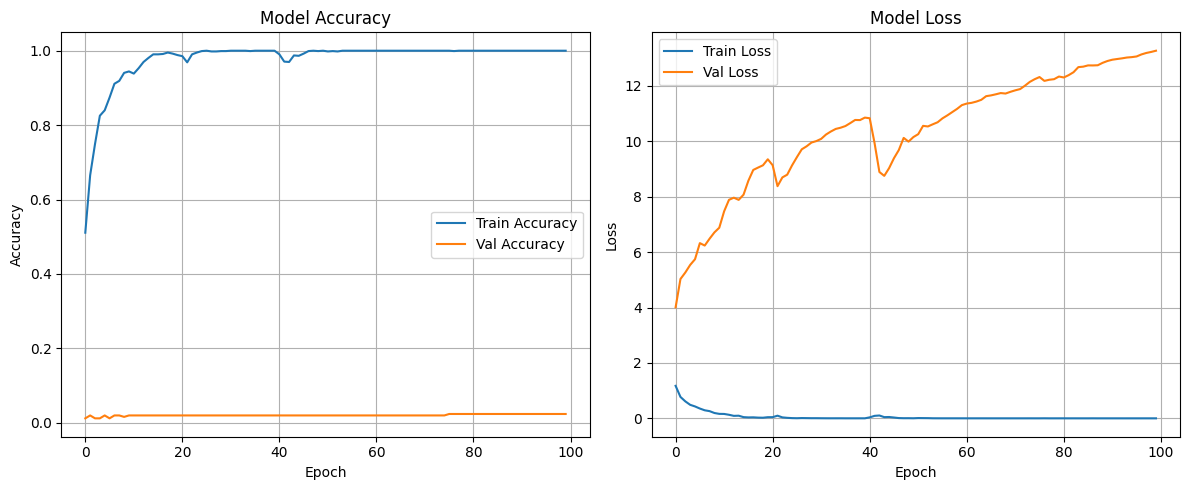

In [21]:
import matplotlib.pyplot as plt

# === Plot training history ===
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
y_pred = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


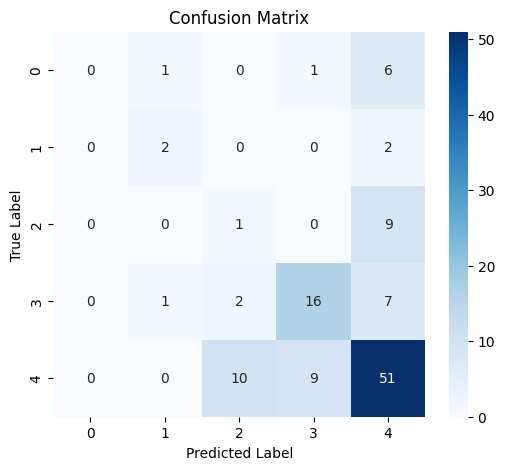

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot using seaborn heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
%pip install -q --disable-pip-version-check onnxruntime tf2onnx onnx

import sys
import tensorflow as tf

# Verify we're installing into the active kernel
print("Python executable:", sys.executable)
print("First sys.path entries:")
print("\n".join(sys.path[:5]))

import tf2onnx
import onnxruntime as rt

output_path = '/Users/gemwincanete/Thesis /models/12.5s/aug_23_2025_bidirectional_lstm_model.onnx'

model.output_names = ['output']

input_signature = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name='input')]
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, output_path=output_path)

Note: you may need to restart the kernel to use updated packages.
Python executable: /Users/gemwincanete/Thesis /.venv/bin/python
First sys.path entries:
/opt/homebrew/Cellar/python@3.10/3.10.17/Frameworks/Python.framework/Versions/3.10/lib/python310.zip
/opt/homebrew/Cellar/python@3.10/3.10.17/Frameworks/Python.framework/Versions/3.10/lib/python3.10
/opt/homebrew/Cellar/python@3.10/3.10.17/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload

/Users/gemwincanete/Thesis /.venv/lib/python3.10/site-packages


I0000 00:00:1757059242.017336  295070 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1757059242.017930  295070 single_machine.cc:374] Starting new session
I0000 00:00:1757059242.321128  295070 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1757059242.321192  295070 single_machine.cc:374] Starting new session
I0000 00:00:1757059242.504889  295070 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
rewriter <function rewrite_constant_fold at 0x17677dea0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
rewriter <function rewrite_constant_fold at 0x17677dea0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
rewriter <function rewrite

In [25]:
output_names = [n.name for n in model_proto.graph.output]

In [26]:
m = rt.InferenceSession(output_path)

correct = 0
wrong = 0

for i in range(len(X_test_final)):
  x = np.float32([X_test_final[i]])
  onnx_pred = m.run(output_names, {"input": x})
  if (np.argmax(onnx_pred[0]) == np.argmax(y_test[i])):
    correct += 1
  else:
    wrong += 1

print(f'Correct: {correct}, Wrong: {wrong}, Total %: {correct / len(X_test_final)}')


Correct: 70, Wrong: 48, Total %: 0.5932203389830508
